<a href="https://colab.research.google.com/github/Gyeong-Hyeon/TRANSLATE-YOUR-PHOTO/blob/main/OCR%2BTranslator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SYSTEM ARCHITECTURE

CHAR DETECTION → CHAR RECOGNITION → TEXT TRANSLATION

* CHAR DETECTION: EAST
* CHAR RECOGNITION: Tesseract
* TEXT TRASLATION: Transformer

#CHAR DETECTION

##DATASET

###Check details of jason file

In [ ]:
import os
import json

base_path = '/content/drive/MyDrive/OCR/dataset/'
with open(os.path.join(base_path, 'COCO_Text.json')) as f:
            coco_data = json.load(f)
coco_data.keys()

dict_keys(['imgs', 'imgToAnns', 'cats', 'anns', 'info'])

Informations and annotation for each image are saved in this jason file.

* imgToAnns: Img - annotation
* imgs: This key has information per img - filename, height, id, set, width - and each information has been divided by information ID as key.
* anns: Textbox information



In [ ]:
#imgToAnns

print('** Total number of images:',len(coco_data['imgToAnns'].keys()))
#print('** Img IDs \n\t:',coco_data['imgToAnns'].keys())
imgids = list(coco_data['imgToAnns'].keys())
print(f"** Textbox ID of img#{imgids[1]}:\n\t {coco_data['imgToAnns'][imgids[1]]}")
textboxids = coco_data['imgToAnns'][imgids[1]]

#imgs
print(f"** Information of img#{imgids[0]}: {coco_data['imgs'][imgids[0]]}")

#anns
#print(f"** Information of textbox#{textboxids[0]} of img#{imgids[0]}:\n\t {coco_data['anns']['1058591']}")

#print(coco_data['cats'].keys())
#print(coco_data['info'].keys())    

** Total number of images: 63686
** Textbox ID of img#287140:
	 [1058591, 1058590]
** Information of img#378466: {'width': 612, 'file_name': 'COCO_train2014_000000378466.jpg', 'set': 'train', 'id': 378466, 'height': 612}


###Load dataset

Load the image data by wget because size is over 12GB

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip -d /content/drive/MyDrive/OCR/dataset/COCO
!rm train2014.zip

In [ ]:
#!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip -d /content/drive/MyDrive/OCR/dataset/COCO
!rm val2014.zip

In [ ]:
%cd /content/drive/MyDrive/OCR
!pwd

/content/drive/MyDrive/OCR
/content/drive/MyDrive/OCR


In [ ]:
import numpy as np
import json
import os

from ssd_data import BaseGTUtility

class GTUtility(BaseGTUtility):
  
    def __init__(self, data_path, validation=False, polygon=False, only_with_label=True):
        test=False
        
        self.data_path = data_path
        gt_path = data_path
        image_path = os.path.join(data_path, 'train2014')
        self.gt_path = gt_path
        self.image_path = image_path
        self.classes = ['Background', 'Text']
        
        self.image_names = []
        self.data = []
        self.text = []
        
        with open(os.path.join(gt_path, 'COCO_Text.json')) as f:
            gt_data = json.load(f)

        for img_id in gt_data['imgToAnns'].keys(): # images
            
            ann_ids = gt_data['imgToAnns'][img_id]

            if len(ann_ids) > 0:
                img_data = gt_data['imgs'][img_id]
                set_type = img_data['set']
            
                if test:
                    if set_type != 'test':
                        continue
                elif validation:
                    if set_type != 'val':
                        continue
                else:
                    if set_type != 'train':
                        continue

                image_name = img_data['file_name']
                img_width = img_data['width']
                img_height = img_data['height']

                boxes = []
                text = []
            
                for ann_id in ann_ids: # boxes
                    ann_data = gt_data['anns'][str(ann_id)]
            
                    if polygon:
                        box = np.array(ann_data['polygon'], dtype=np.float32)
                    else:
                        x, y, w, h = np.array(ann_data['bbox'], dtype=np.float32)
                        box = np.array([x, y, x+w, y+h])
                    
                    if 'utf8_string' in ann_data.keys():
                        txt = ann_data['utf8_string']
                    else:
                        if only_with_label:
                            continue
                        else:
                            txt = ''
                    
                    boxes.append(box)
                    text.append(txt)
                
                if len(boxes) == 0:
                    continue
                
                boxes = np.asarray(boxes)
                
                boxes[:,0::2] /= img_width
                boxes[:,1::2] /= img_height
                    
                # append classes
                boxes = np.concatenate([boxes, np.ones([boxes.shape[0],1])], axis=1)
                
                self.image_names.append(image_name)
                self.data.append(boxes)
                self.text.append(text)
                
        self.init()

In [ ]:
import pickle

gt_util_train = GTUtility('dataset/COCO', polygon=True)
gt_util_val = GTUtility('dataset/COCO', validation = True, polygon=True)

file_name_train = 'gt_util_cocotext_train.pkl'
file_name_val = 'gt_util_cocotext_val.pkl'

pickle.dump(gt_util_train, open(file_name_train,'wb'))
pickle.dump(gt_util_val, open(file_name_val,'wb'))

print('Train:')
print(gt_util_train)
print('--------------------------\nValidation:')
print(gt_util_val)

Train:
Background              0
Text                68736

images              14708
objects             68736
per image            4.67
no annotation           0

--------------------------
Validation:
Background              0
Text                15679

images               3424
objects             15679
per image            4.58
no annotation           0



In [ ]:
import pickle

# Train
with open('gt_util_cocotext_train.pkl', 'rb') as f:
    gt_util_train = pickle.load(f)
 
# Validation 
with open('gt_util_cocotext_val.pkl', 'rb') as f:
    gt_util_val = pickle.load(f)

##EAST

In [ ]:
!tar -xvzf /content/drive/MyDrive/OCR/model/frozen_east_text_detection.tar.gz

frozen_east_text_detection.pb


loading EAST text detector...
[INFO] text detection took 0.649299 seconds


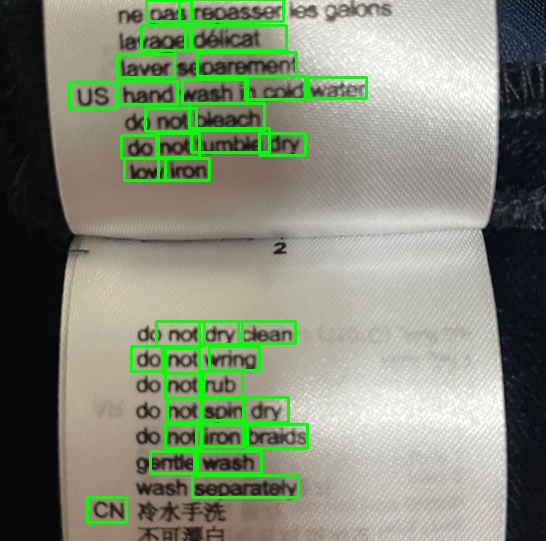

loading EAST text detector...
[INFO] text detection took 0.651697 seconds


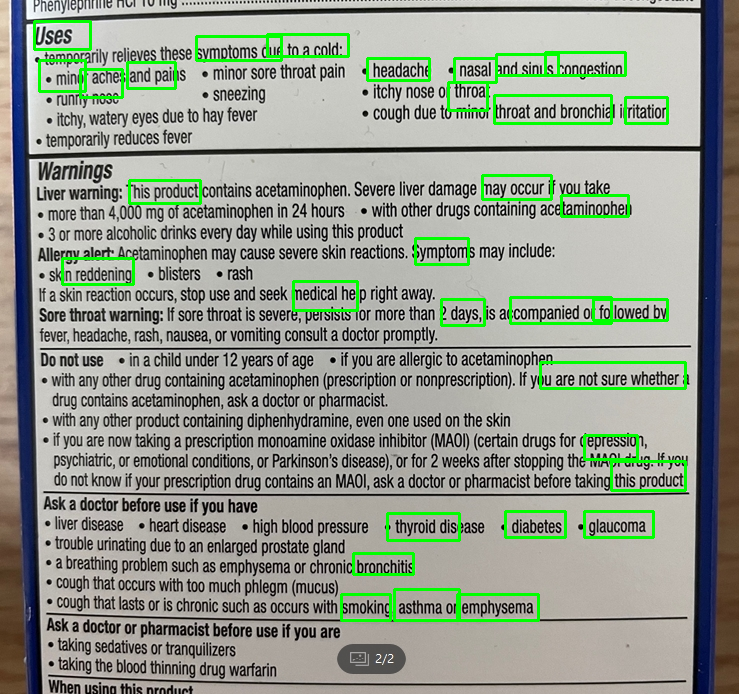

In [ ]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import time
import cv2

def detector(imgpath):
  image = cv2.imread(imgpath)
  orig = image.copy()
  (H, W) = image.shape[:2]

  # set the new width and height and then determine the ratio in change
  # for both the width and height
  # 사이즈 
  # (newW, newH) = (args["width"], args["height"])
  (newW, newH) = (320, 320)
  rW = W / float(newW)
  rH = H / float(newH)

  # resize the image and grab the new image dimensions
  image = cv2.resize(image, (newW, newH))
  (H, W) = image.shape[:2]

  # define the two output layer names for the EAST detector model that
  # we are interested -- the first is the output probabilities and the
  # second can be used to derive the bounding box coordinates of text
  layerNames = [
  "feature_fusion/Conv_7/Sigmoid",
  "feature_fusion/concat_3"]

  # load the pre-trained EAST text detector
  print("loading EAST text detector...")

  # 모델 입력
  net = cv2.dnn.readNet("/content/drive/MyDrive/OCR/model/frozen_east_text_detection.pb")

  # construct a blob from the image and then perform a forward pass of
  # the model to obtain the two output layer sets
  blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
  start = time.time()
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
  end = time.time()

  # show timing information on text prediction
  print("[INFO] text detection took {:.6f} seconds".format(end - start))

  # grab the number of rows and columns from the scores volume, then
  # initialize our set of bounding box rectangles and corresponding
  # confidence scores
  (numRows, numCols) = scores.shape[2:4]
  rects = []
  confidences = []

  # loop over the number of rows
  for y in range(0, numRows):
  # extract the scores (probabilities), followed by the geometrical
  # data used to derive potential bounding box coordinates that
  # surround text
      scoresData = scores[0, 0, y]
      xData0 = geometry[0, 0, y]
      xData1 = geometry[0, 1, y]
      xData2 = geometry[0, 2, y]
      xData3 = geometry[0, 3, y]
      anglesData = geometry[0, 4, y]

  # loop over the number of columns
      for x in range(0, numCols):
  # if our score does not have sufficient probability, ignore it
  #       if scoresData[x] < args["min_confidence"]:
          if scoresData[x] < 0.5:
              continue

          # compute the offset factor as our resulting feature maps will
          # be 4x smaller than the input image
          (offsetX, offsetY) = (x * 4.0, y * 4.0)

          # extract the rotation angle for the prediction and then
          # compute the sin and cosine
          angle = anglesData[x]
          cos = np.cos(angle)
          sin = np.sin(angle)

          # use the geometry volume to derive the width and height of
          # the bounding box
          h = xData0[x] + xData2[x]
          w = xData1[x] + xData3[x]

          # compute both the starting and ending (x, y)-coordinates for
          # the text prediction bounding box
          endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
          endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
          startX = int(endX - w)
          startY = int(endY - h)

          # add the bounding box coordinates and probability score to
          # our respective lists
          rects.append((startX, startY, endX, endY))
          confidences.append(scoresData[x])

  # apply non-maxima suppression to suppress weak, overlapping bounding
  # boxes
  boxes = non_max_suppression(np.array(rects), probs=confidences)

  # loop over the bounding boxes
  for (startX, startY, endX, endY) in boxes:
      # scale the bounding box coordinates based on the respective
      # ratios
      startX = int(startX * rW)
      startY = int(startY * rH)
      endX = int(endX * rW)
      endY = int(endY * rH)

      # draw the bounding box on the image
      cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
  return orig

# show the output image
#cv2_imshow(detector('/content/drive/MyDrive/OCR/img/Englishmenu.jpg'))
#cv2_imshow(detector('/content/drive/MyDrive/OCR/img/bodyscrub.jpg'))
cv2_imshow(detector('/content/drive/MyDrive/OCR/img/care.jpg'))
cv2_imshow(detector('/content/drive/MyDrive/OCR/img/drug.jpg'))

##ADVANCED EAST

###Modify config

In [ ]:
import os

train_task_id = '3T256'
initial_epoch = 0
epoch_num = 24
learning_rate = 1e-3
decay = 5e-4
# clipvalue = 0.5  # default 0.5, 0 means no clip
patience = 5
load_weights = False
lambda_inside_score_loss = 4.0
lambda_side_vertex_code_loss = 1.0
lambda_side_vertex_coord_loss = 1.0

total_img = 10000
validation_split_ratio = 0.1
max_train_img_size = int(train_task_id[-3:])
max_predict_img_size = int(train_task_id[-3:])  # 2400
assert max_train_img_size in [256, 384, 512, 640, 736], \
    'max_train_img_size must in [256, 384, 512, 640, 736]'
if max_train_img_size == 256:
    batch_size = 8
elif max_train_img_size == 384:
    batch_size = 4
elif max_train_img_size == 512:
    batch_size = 2
else:
    batch_size = 1
steps_per_epoch = total_img * (1 - validation_split_ratio) // batch_size
validation_steps = total_img * validation_split_ratio // batch_size

training_data_path = '/content/drive/MyDrive/OCR/dataset/COCO/train2014/'
show_gt_image_dir_name = '/content/drive/MyDrive/OCR/img/show_gt_images_%s/' % train_task_id
show_act_image_dir_name = '/content/drive/MyDrive/OCR/img/show_act_images_%s/' % train_task_id
gen_origin_img = True
draw_gt_quad = True
draw_act_quad = True

# in paper it's 0.3, maybe to large to this problem
shrink_ratio = 0.2
# pixels between 0.2 and 0.6 are side pixels
shrink_side_ratio = 0.6
epsilon = 1e-4

num_channels = 3
feature_layers_range = range(5, 1, -1)
# feature_layers_range = range(3, 0, -1)
feature_layers_num = len(feature_layers_range)
# pixel_size = 4
pixel_size = 2 ** feature_layers_range[-1]
locked_layers = False

if not os.path.exists('model'):
    os.mkdir('model')
if not os.path.exists('saved_model'):
    os.mkdir('saved_model')

model_weights_path = '/content/drive/MyDrive/OCR/model/weights/weights_%s.{epoch:03d}-{val_loss:.3f}.h5' \
                     % train_task_id
saved_model_file_path = '/content/drive/MyDrive/OCR/saved_model/east_model_%s.h5' % train_task_id
saved_model_weights_file_path = '/content/drive/MyDrive/OCR/saved_model/east_model_weights_%s.h5'\
                                % train_task_id

pixel_threshold = 0.9
side_vertex_pixel_threshold = 0.9
trunc_threshold = 0.1
predict_cut_text_line = False
predict_write2txt = True

###Data preprocessing

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import os
import random
from tqdm import tqdm

#####LABELS#####
def point_inside_of_quad(px, py, quad_xy_list, p_min, p_max):
    if (p_min[0] <= px <= p_max[0]) and (p_min[1] <= py <= p_max[1]):
        xy_list = np.zeros((4, 2))
        xy_list[:3, :] = quad_xy_list[1:4, :] - quad_xy_list[:3, :]
        xy_list[3] = quad_xy_list[0, :] - quad_xy_list[3, :]
        yx_list = np.zeros((4, 2))
        yx_list[:, :] = quad_xy_list[:, -1:-3:-1]
        a = xy_list * ([py, px] - yx_list)
        b = a[:, 0] - a[:, 1]
        if np.amin(b) >= 0 or np.amax(b) <= 0:
            return True
        else:
            return False
    else:
        return False


def point_inside_of_nth_quad(px, py, xy_list, shrink_1, long_edge):
    nth = -1
    vs = [[[0, 0, 3, 3, 0], [1, 1, 2, 2, 1]],
          [[0, 0, 1, 1, 0], [2, 2, 3, 3, 2]]]
    for ith in range(2):
        quad_xy_list = np.concatenate((
            np.reshape(xy_list[vs[long_edge][ith][0]], (1, 2)),
            np.reshape(shrink_1[vs[long_edge][ith][1]], (1, 2)),
            np.reshape(shrink_1[vs[long_edge][ith][2]], (1, 2)),
            np.reshape(xy_list[vs[long_edge][ith][3]], (1, 2))), axis=0)
        p_min = np.amin(quad_xy_list, axis=0)
        p_max = np.amax(quad_xy_list, axis=0)
        if point_inside_of_quad(px, py, quad_xy_list, p_min, p_max):
            if nth == -1:
                nth = ith
            else:
                nth = -1
                break
    return nth


def shrink(xy_list, ratio=shrink_ratio):
    if ratio == 0.0:
        return xy_list, xy_list
    diff_1to3 = xy_list[:3, :] - xy_list[1:4, :]
    diff_4 = xy_list[3:4, :] - xy_list[0:1, :]
    diff = np.concatenate((diff_1to3, diff_4), axis=0)
    dis = np.sqrt(np.sum(np.square(diff), axis=-1))
    # determine which are long or short edges
    long_edge = int(np.argmax(np.sum(np.reshape(dis, (2, 2)), axis=0)))
    short_edge = 1 - long_edge
    # cal r length array
    r = [np.minimum(dis[i], dis[(i + 1) % 4]) for i in range(4)]
    # cal theta array
    diff_abs = np.abs(diff)
    diff_abs[:, 0] += epsilon
    theta = np.arctan(diff_abs[:, 1] / diff_abs[:, 0])
    # shrink two long edges
    temp_new_xy_list = np.copy(xy_list)
    shrink_edge(xy_list, temp_new_xy_list, long_edge, r, theta, ratio)
    shrink_edge(xy_list, temp_new_xy_list, long_edge + 2, r, theta, ratio)
    # shrink two short edges
    new_xy_list = np.copy(temp_new_xy_list)
    shrink_edge(temp_new_xy_list, new_xy_list, short_edge, r, theta, ratio)
    shrink_edge(temp_new_xy_list, new_xy_list, short_edge + 2, r, theta, ratio)
    return temp_new_xy_list, new_xy_list, long_edge


def shrink_edge(xy_list, new_xy_list, edge, r, theta, ratio=shrink_ratio):
    if ratio == 0.0:
        return
    start_point = edge
    end_point = (edge + 1) % 4
    long_start_sign_x = np.sign(
        xy_list[end_point, 0] - xy_list[start_point, 0])
    new_xy_list[start_point, 0] = \
        xy_list[start_point, 0] + \
        long_start_sign_x * ratio * r[start_point] * np.cos(theta[start_point])
    long_start_sign_y = np.sign(
        xy_list[end_point, 1] - xy_list[start_point, 1])
    new_xy_list[start_point, 1] = \
        xy_list[start_point, 1] + \
        long_start_sign_y * ratio * r[start_point] * np.sin(theta[start_point])
    # long edge one, end point
    long_end_sign_x = -1 * long_start_sign_x
    new_xy_list[end_point, 0] = \
        xy_list[end_point, 0] + \
        long_end_sign_x * ratio * r[end_point] * np.cos(theta[start_point])
    long_end_sign_y = -1 * long_start_sign_y
    new_xy_list[end_point, 1] = \
        xy_list[end_point, 1] + \
        long_end_sign_y * ratio * r[end_point] * np.sin(theta[start_point])


def process_label(data_dir=data_dir):
    with open(os.path.join(data_dir, val_fname), 'r') as f_val:
        f_list = f_val.readlines()
    with open(os.path.join(data_dir, train_fname), 'r') as f_train:
        f_list.extend(f_train.readlines())
    for line, _ in zip(f_list, tqdm(range(len(f_list)))):
        line_cols = str(line).strip().split(',')
        img_name, width, height = \
            line_cols[0].strip(), int(line_cols[1].strip()), \
            int(line_cols[2].strip())
        gt = np.zeros((height // pixel_size, width // pixel_size, 7))
        train_label_dir = os.path.join(data_dir, train_label_dir_name)
        xy_list_array = np.load(os.path.join(train_label_dir,
                                             img_name[:-4] + '.npy'))
        train_image_dir = os.path.join(data_dir, train_image_dir_name)
        with Image.open(os.path.join(train_image_dir, img_name)) as im:
            draw = ImageDraw.Draw(im)
            for xy_list in xy_list_array:
                _, shrink_xy_list, _ = shrink(xy_list, shrink_ratio)
                shrink_1, _, long_edge = shrink(xy_list, shrink_side_ratio)
                p_min = np.amin(shrink_xy_list, axis=0)
                p_max = np.amax(shrink_xy_list, axis=0)
                # floor of the float
                ji_min = (p_min / pixel_size - 0.5).astype(int) - 1
                # +1 for ceil of the float and +1 for include the end
                ji_max = (p_max / pixel_size - 0.5).astype(int) + 3
                imin = np.maximum(0, ji_min[1])
                imax = np.minimum(height // pixel_size, ji_max[1])
                jmin = np.maximum(0, ji_min[0])
                jmax = np.minimum(width // pixel_size, ji_max[0])
                for i in range(imin, imax):
                    for j in range(jmin, jmax):
                        px = (j + 0.5) * pixel_size
                        py = (i + 0.5) * pixel_size
                        if point_inside_of_quad(px, py,
                                                shrink_xy_list, p_min, p_max):
                            gt[i, j, 0] = 1
                            line_width, line_color = 1, 'red'
                            ith = point_inside_of_nth_quad(px, py,
                                                           xy_list,
                                                           shrink_1,
                                                           long_edge)
                            vs = [[[3, 0], [1, 2]], [[0, 1], [2, 3]]]
                            if ith in range(2):
                                gt[i, j, 1] = 1
                                if ith == 0:
                                    line_width, line_color = 2, 'yellow'
                                else:
                                    line_width, line_color = 2, 'green'
                                gt[i, j, 2:3] = ith
                                gt[i, j, 3:5] = \
                                    xy_list[vs[long_edge][ith][0]] - [px, py]
                                gt[i, j, 5:] = \
                                    xy_list[vs[long_edge][ith][1]] - [px, py]
                            draw.line([(px - 0.5 * pixel_size,
                                        py - 0.5 * pixel_size),
                                       (px + 0.5 * pixel_size,
                                        py - 0.5 * pixel_size),
                                       (px + 0.5 * pixel_size,
                                        py + 0.5 * pixel_size),
                                       (px - 0.5 * pixel_size,
                                        py + 0.5 * pixel_size),
                                       (px - 0.5 * pixel_size,
                                        py - 0.5 * pixel_size)],
                                      width=line_width, fill=line_color)
            act_image_dir = os.path.join(data_dir,
                                         show_act_image_dir_name)
            if draw_act_quad:
                im.save(os.path.join(act_image_dir, img_name))
        train_label_dir = os.path.join(data_dir, train_label_dir_name)
        np.save(os.path.join(train_label_dir,
                             img_name[:-4] + '_gt.npy'), gt)

def batch_reorder_vertexes(xy_list_array):
    reorder_xy_list_array = np.zeros_like(xy_list_array)
    for xy_list, i in zip(xy_list_array, range(len(xy_list_array))):
        reorder_xy_list_array[i] = reorder_vertexes(xy_list)
    return reorder_xy_list_array

#####PREPROCESSING#####
def reorder_vertexes(xy_list):
    reorder_xy_list = np.zeros_like(xy_list)
    # determine the first point with the smallest x,
    # if two has same x, choose that with smallest y,
    ordered = np.argsort(xy_list, axis=0)
    xmin1_index = ordered[0, 0]
    xmin2_index = ordered[1, 0]
    if xy_list[xmin1_index, 0] == xy_list[xmin2_index, 0]:
        if xy_list[xmin1_index, 1] <= xy_list[xmin2_index, 1]:
            reorder_xy_list[0] = xy_list[xmin1_index]
            first_v = xmin1_index
        else:
            reorder_xy_list[0] = xy_list[xmin2_index]
            first_v = xmin2_index
    else:
        reorder_xy_list[0] = xy_list[xmin1_index]
        first_v = xmin1_index
    # connect the first point to others, the third point on the other side of
    # the line with the middle slope
    others = list(range(4))
    others.remove(first_v)
    k = np.zeros((len(others),))
    for index, i in zip(others, range(len(others))):
        k[i] = (xy_list[index, 1] - xy_list[first_v, 1]) \
                    / (xy_list[index, 0] - xy_list[first_v, 0] + epsilon)
    k_mid = np.argsort(k)[1]
    third_v = others[k_mid]
    reorder_xy_list[2] = xy_list[third_v]
    # determine the second point which on the bigger side of the middle line
    others.remove(third_v)
    b_mid = xy_list[first_v, 1] - k[k_mid] * xy_list[first_v, 0]
    second_v, fourth_v = 0, 0
    for index, i in zip(others, range(len(others))):
        # delta = y - (k * x + b)
        delta_y = xy_list[index, 1] - (k[k_mid] * xy_list[index, 0] + b_mid)
        if delta_y > 0:
            second_v = index
        else:
            fourth_v = index
    reorder_xy_list[1] = xy_list[second_v]
    reorder_xy_list[3] = xy_list[fourth_v]
    # compare slope of 13 and 24, determine the final order
    k13 = k[k_mid]
    k24 = (xy_list[second_v, 1] - xy_list[fourth_v, 1]) / (
                xy_list[second_v, 0] - xy_list[fourth_v, 0] + epsilon)
    if k13 < k24:
        tmp_x, tmp_y = reorder_xy_list[3, 0], reorder_xy_list[3, 1]
        for i in range(2, -1, -1):
            reorder_xy_list[i + 1] = reorder_xy_list[i]
        reorder_xy_list[0, 0], reorder_xy_list[0, 1] = tmp_x, tmp_y
    return reorder_xy_list


def resize_image(im, max_img_size=max_train_img_size):
    im_width = np.minimum(im.width, max_img_size)
    if im_width == max_img_size < im.width:
        im_height = int((im_width / im.width) * im.height)
    else:
        im_height = im.height
    o_height = np.minimum(im_height, max_img_size)
    if o_height == max_img_size < im_height:
        o_width = int((o_height / im_height) * im_width)
    else:
        o_width = im_width
    d_wight = o_width - (o_width % 32)
    d_height = o_height - (o_height % 32)
    return d_wight, d_height


def preprocess():
    data_dir = data_dir
    origin_image_dir = os.path.join(data_dir, origin_image_dir_name)
    origin_txt_dir = os.path.join(data_dir, origin_txt_dir_name)
    train_image_dir = os.path.join(data_dir, train_image_dir_name)
    train_label_dir = os.path.join(data_dir, train_label_dir_name)
    if not os.path.exists(train_image_dir):
        os.mkdir(train_image_dir)
    if not os.path.exists(train_label_dir):
        os.mkdir(train_label_dir)
    draw_gt_quad = draw_gt_quad
    show_gt_image_dir = os.path.join(data_dir, show_gt_image_dir_name)
    if not os.path.exists(show_gt_image_dir):
        os.mkdir(show_gt_image_dir)
    show_act_image_dir = os.path.join(data_dir, show_act_image_dir_name)
    if not os.path.exists(show_act_image_dir):
        os.mkdir(show_act_image_dir)

    o_img_list = os.listdir(origin_image_dir)
    print('found %d origin images.' % len(o_img_list))
    train_val_set = []
    for o_img_fname, _ in zip(o_img_list, tqdm(range(len(o_img_list)))):
        with Image.open(os.path.join(origin_image_dir, o_img_fname)) as im:
            # d_wight, d_height = resize_image(im)
            d_wight, d_height = max_train_img_size, max_train_img_size
            scale_ratio_w = d_wight / im.width
            scale_ratio_h = d_height / im.height
            im = im.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
            show_gt_im = im.copy()
            # draw on the img
            draw = ImageDraw.Draw(show_gt_im)
            with open(os.path.join(origin_txt_dir,
                                   o_img_fname[:-4] + '.txt'), 'r') as f:
                anno_list = f.readlines()
            xy_list_array = np.zeros((len(anno_list), 4, 2))
            for anno, i in zip(anno_list, range(len(anno_list))):
                anno_colums = anno.strip().split(',')
                anno_array = np.array(anno_colums)
                xy_list = np.reshape(anno_array[:8].astype(float), (4, 2))
                xy_list[:, 0] = xy_list[:, 0] * scale_ratio_w
                xy_list[:, 1] = xy_list[:, 1] * scale_ratio_h
                xy_list = reorder_vertexes(xy_list)
                xy_list_array[i] = xy_list
                _, shrink_xy_list, _ = shrink(xy_list, shrink_ratio)
                shrink_1, _, long_edge = shrink(xy_list, shrink_side_ratio)
                if draw_gt_quad:
                    draw.line([tuple(xy_list[0]), tuple(xy_list[1]),
                               tuple(xy_list[2]), tuple(xy_list[3]),
                               tuple(xy_list[0])
                               ],
                              width=2, fill='green')
                    draw.line([tuple(shrink_xy_list[0]),
                               tuple(shrink_xy_list[1]),
                               tuple(shrink_xy_list[2]),
                               tuple(shrink_xy_list[3]),
                               tuple(shrink_xy_list[0])
                               ],
                              width=2, fill='blue')
                    vs = [[[0, 0, 3, 3, 0], [1, 1, 2, 2, 1]],
                          [[0, 0, 1, 1, 0], [2, 2, 3, 3, 2]]]
                    for q_th in range(2):
                        draw.line([tuple(xy_list[vs[long_edge][q_th][0]]),
                                   tuple(shrink_1[vs[long_edge][q_th][1]]),
                                   tuple(shrink_1[vs[long_edge][q_th][2]]),
                                   tuple(xy_list[vs[long_edge][q_th][3]]),
                                   tuple(xy_list[vs[long_edge][q_th][4]])],
                                  width=3, fill='yellow')
            if gen_origin_img:
                im.save(os.path.join(train_image_dir, o_img_fname))
            np.save(os.path.join(
                train_label_dir,
                o_img_fname[:-4] + '.npy'),
                xy_list_array)
            if draw_gt_quad:
                show_gt_im.save(os.path.join(show_gt_image_dir, o_img_fname))
            train_val_set.append('{},{},{}\n'.format(o_img_fname,
                                                     d_wight,
                                                     d_height))

    train_img_list = os.listdir(train_image_dir)
    print('found %d train images.' % len(train_img_list))
    train_label_list = os.listdir(train_label_dir)
    print('found %d train labels.' % len(train_label_list))

    random.shuffle(train_val_set)
    val_count = int(validation_split_ratio * len(train_val_set))
    with open(os.path.join(data_dir, val_fname), 'w') as f_val:
        f_val.writelines(train_val_set[:val_count])
    with open(os.path.join(data_dir, train_fname), 'w') as f_train:
        f_train.writelines(train_val_set[val_count:])

NameError: ignored

###Model

In [ ]:
from keras import Input, Model
from keras.applications.vgg16 import VGG16
from keras.layers import Concatenate, Conv2D, UpSampling2D, BatchNormalization

"""
input_shape=(img.height, img.width, 3), height and width must scaled by 32.
So images's height and width need to be pre-processed to the nearest num that
scaled by 32.And the annotations xy need to be scaled by the same ratio 
as height and width respectively.
"""

class East:

    def __init__(self):
        global locked_layers
        self.input_img = Input(name='input_img',
                               shape=(None, None, num_channels),
                               dtype='float32')
        vgg16 = VGG16(input_tensor=self.input_img,
                      weights='imagenet',
                      include_top=False)
        if locked_layers:
            # locked first two conv layers
            locked_layers = [vgg16.get_layer('block1_conv1'),
                             vgg16.get_layer('block1_conv2')]
            for layer in locked_layers:
                layer.trainable = False
        self.f = [vgg16.get_layer('block%d_pool' % i).output
                  for i in feature_layers_range]
        self.f.insert(0, None)
        self.diff = feature_layers_range[0] - feature_layers_num

    def g(self, i):
        # i+diff in feature_layers_range
        assert i + self.diff in feature_layers_range, \
            ('i=%d+diff=%d not in ' % (i, self.diff)) + \
            str(feature_layers_range)
        if i == feature_layers_num:
            bn = BatchNormalization()(self.h(i))
            return Conv2D(32, 3, activation='relu', padding='same')(bn)
        else:
            return UpSampling2D((2, 2))(self.h(i))

    def h(self, i):
        # i+diff in feature_layers_range
        assert i + self.diff in feature_layers_range, \
            ('i=%d+diff=%d not in ' % (i, self.diff)) + \
            str(feature_layers_range)
        if i == 1:
            return self.f[i]
        else:
            concat = Concatenate(axis=-1)([self.g(i - 1), self.f[i]])
            bn1 = BatchNormalization()(concat)
            conv_1 = Conv2D(128 // 2 ** (i - 2), 1,
                            activation='relu', padding='same',)(bn1)
            bn2 = BatchNormalization()(conv_1)
            conv_3 = Conv2D(128 // 2 ** (i - 2), 3,
                            activation='relu', padding='same',)(bn2)
            return conv_3

    def east_network(self):
        before_output = self.g(feature_layers_num)
        inside_score = Conv2D(1, 1, padding='same', name='inside_score'
                              )(before_output)
        side_v_code = Conv2D(2, 1, padding='same', name='side_vertex_code'
                             )(before_output)
        side_v_coord = Conv2D(4, 1, padding='same', name='side_vertex_coord'
                              )(before_output)
        east_detect = Concatenate(axis=-1,
                                  name='east_detect')([inside_score,
                                                       side_v_code,
                                                       side_v_coord])
        return Model(inputs=self.input_img, outputs=east_detect)

east = East()
east_network = east.east_network()
east_network.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_img[0][0]                  
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Set loss

In [ ]:
import tensorflow as tf

def quad_loss(y_true, y_pred):
    # loss for inside_score
    logits = y_pred[:, :, :, :1]
    labels = y_true[:, :, :, :1]
    # balance positive and negative samples in an image
    beta = 1 - tf.reduce_mean(labels)
    # first apply sigmoid activation
    predicts = tf.nn.sigmoid(logits)
    # log +epsilon for stable cal
    inside_score_loss = tf.reduce_mean(
        -1 * (beta * labels * tf.log(predicts + epsilon) +
              (1 - beta) * (1 - labels) * tf.log(1 - predicts + epsilon)))
    inside_score_loss *= lambda_inside_score_loss

    # loss for side_vertex_code
    vertex_logits = y_pred[:, :, :, 1:3]
    vertex_labels = y_true[:, :, :, 1:3]
    vertex_beta = 1 - (tf.reduce_mean(y_true[:, :, :, 1:2])
                       / (tf.reduce_mean(labels) + epsilon))
    vertex_predicts = tf.nn.sigmoid(vertex_logits)
    pos = -1 * vertex_beta * vertex_labels * tf.log(vertex_predicts +
                                                    epsilon)
    neg = -1 * (1 - vertex_beta) * (1 - vertex_labels) * tf.log(
        1 - vertex_predicts + epsilon)
    positive_weights = tf.cast(tf.equal(y_true[:, :, :, 0], 1), tf.float32)
    side_vertex_code_loss = \
        tf.reduce_sum(tf.reduce_sum(pos + neg, axis=-1) * positive_weights) / (
                tf.reduce_sum(positive_weights) + epsilon)
    side_vertex_code_loss *= lambda_side_vertex_code_loss

    # loss for side_vertex_coord delta
    g_hat = y_pred[:, :, :, 3:]
    g_true = y_true[:, :, :, 3:]
    vertex_weights = tf.cast(tf.equal(y_true[:, :, :, 1], 1), tf.float32)
    pixel_wise_smooth_l1norm = smooth_l1_loss(g_hat, g_true, vertex_weights)
    side_vertex_coord_loss = tf.reduce_sum(pixel_wise_smooth_l1norm) / (
            tf.reduce_sum(vertex_weights) + epsilon)
    side_vertex_coord_loss *= lambda_side_vertex_coord_loss
    return inside_score_loss + side_vertex_code_loss + side_vertex_coord_loss


def smooth_l1_loss(prediction_tensor, target_tensor, weights):
    n_q = tf.reshape(quad_norm(target_tensor), tf.shape(weights))
    diff = prediction_tensor - target_tensor
    abs_diff = tf.abs(diff)
    abs_diff_lt_1 = tf.less(abs_diff, 1)
    pixel_wise_smooth_l1norm = (tf.reduce_sum(
        tf.where(abs_diff_lt_1, 0.5 * tf.square(abs_diff), abs_diff - 0.5),
        axis=-1) / n_q) * weights
    return pixel_wise_smooth_l1norm


def quad_norm(g_true):
    shape = tf.shape(g_true)
    delta_xy_matrix = tf.reshape(g_true, [-1, 2, 2])
    diff = delta_xy_matrix[:, 0:1, :] - delta_xy_matrix[:, 1:2, :]
    square = tf.square(diff)
    distance = tf.sqrt(tf.reduce_sum(square, axis=-1))
    distance *= 4.0
    distance += epsilon
    return tf.reshape(distance, shape[:-1])

Data generator

In [ ]:
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

def gen(batch_size=batch_size, is_val=False):
    img_h, img_w = max_train_img_size, max_train_img_size
    x = np.zeros((batch_size, img_h, img_w, num_channels), dtype=np.float32)
    pixel_num_h = img_h // pixel_size
    pixel_num_w = img_w // pixel_size
    y = np.zeros((batch_size, pixel_num_h, pixel_num_w, 7), dtype=np.float32)
    if is_val:
        with open(os.path.join(data_dir, val_fname), 'r') as f_val:
            f_list = f_val.readlines()
    else:
        with open(os.path.join(data_dir, train_fname), 'r') as f_train:
            f_list = f_train.readlines()
    while True:
        for i in range(batch_size):
            # random gen an image name
            random_img = np.random.choice(f_list)
            img_filename = str(random_img).strip().split(',')[0]
            # load img and img anno
            img_path = os.path.join(data_dir,
                                    train_image_dir_name,
                                    img_filename)
            img = image.load_img(img_path)
            img = image.img_to_array(img)
            x[i] = preprocess_input(img, mode='tf')
            gt_file = os.path.join(data_dir,
                                   train_label_dir_name,
                                   img_filename[:-4] + '_gt.npy')
            y[i] = np.load(gt_file)
        yield x, y

In [ ]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

east = East()
east_network = east.east_network()
east_network.compile(loss=quad_loss, optimizer=Adam(lr=learning_rate,
                                                    # clipvalue=clipvalue,
                                                    decay=decay))
if load_weights and os.path.exists(saved_model_weights_file_path):
    east_network.load_weights(saved_model_weights_file_path)

east_network.fit_generator(generator=gen(),
                           steps_per_epoch=steps_per_epoch,
                           epochs=epoch_num,
                           validation_data=gen(is_val=True),
                           validation_steps=validation_steps,
                           verbose=1,
                           initial_epoch=initial_epoch,
                           callbacks=[
                               EarlyStopping(patience=patience, verbose=1),
                               ModelCheckpoint(filepath=model_weights_path,
                                               save_best_only=True,
                                               save_weights_only=True,
                                               verbose=1)])
east_network.save(saved_model_file_path)
east_network.save_weights(saved_model_weights_file_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


FileNotFoundError: ignored

##CRNN

Paper: https://arxiv.org/abs/1507.05717

Repository: https://github.com/mvoelk/ssd_detectors

###Modify config

In [ ]:
#import string

# alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits + ' +-*.,:!?%&$~/()[]<>"\'@#_'

# input_width = 256
# input_height = 32
batch_size = 128

# input_shape = (input_width, input_height, 1)

freeze = ['conv1_1',
          'conv2_1',
          'conv3_1',
          'conv3_2', 
          'conv4_1',
          'conv5_1' ]

experiment = 'dsdo_pretrained'
epoch = 200
initial_epoch = 0
#max_string_len = model_pred.output_shape[1]

###Build Seglink with DSOD Model

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers

class Normalize(Layer):
    """Normalization layer as described in ParseNet paper.
    # Arguments
        scale: Default feature scale.
    # Input shape
        4D tensor with shape: (samples, rows, cols, channels)
    # Output shape
        Same as input
    # References
        http://cs.unc.edu/~wliu/papers/parsenet.pdf
    # TODO
        Add possibility to have one scale for all features.
    """
    def __init__(self, scale=20, **kwargs):
        self.scale = scale
        super(Normalize, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name=self.name+'_gamma', 
                                     shape=(input_shape[-1],),
                                     initializer=initializers.Constant(self.scale), 
                                     trainable=True)
        super(Normalize, self).build(input_shape)
        
    def call(self, x, mask=None):
        return self.gamma * K.l2_normalize(x, axis=-1)

In [ ]:
from tensorflow.keras.layers import Reshape, Flatten, concatenate, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def bn_acti_conv(x, filters, kernel_size=1, stride=1, padding='same', activation='relu'):
    x = BatchNormalization(scale=True)(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    return x

def dense_block(x, n, growth_rate, width=4, activation='relu'):
    input_shape = K.int_shape(x)
    c = input_shape[3]
    for i in range(n):
        x1 = x
        x2 = bn_acti_conv(x, growth_rate*width, 1, 1, activation=activation)
        x2 = bn_acti_conv(x2, growth_rate, 3, 1, activation=activation)
        x = concatenate([x1, x2], axis=3)
        c += growth_rate
    return x

def downsampling_block(x, filters, width, padding='same', activation='relu'):
    x1 = MaxPooling2D(pool_size=2, strides=2, padding=padding)(x)
    x1 = bn_acti_conv(x1, filters, 1, 1, padding, activation=activation)
    x2 = bn_acti_conv(x, filters*width, 1, 1, padding, activation=activation)
    x2 = bn_acti_conv(x2, filters, 3, 2, padding, activation=activation)
    return concatenate([x1, x2], axis=3)

def multibox_head(source_layers, num_priors, normalizations=None, softmax=True):
    
    class_activation = 'softmax' if softmax else 'sigmoid'
    
    mbox_conf = []
    mbox_loc = []
    link_interlayer_conf = []
    link_crosslayer_conf = []
    for i in range(len(source_layers)):
        x = source_layers[i]
        name = x.name.split('/')[0]
        
        # normalize
        if normalizations is not None and normalizations[i] > 0:
            name = name + '_norm'
            x = Normalize(normalizations[i], name=name)(x)
            
        # confidence
        name1 = name + '_mbox_conf'
        x1 = Conv2D(num_priors[i] * 2, 3, padding='same', name=name1)(x)
        x1 = Flatten(name=name1+'_flat')(x1)
        mbox_conf.append(x1)

        # location
        name2 = name + '_mbox_loc'
        x2 = Conv2D(num_priors[i] * 5, 3, padding='same', name=name2)(x)
        x2 = Flatten(name=name2+'_flat')(x2)
        mbox_loc.append(x2)
        
        # link interlayer confidenc
        name3 = name + '_link_interlayer_conf'
        x3 = Conv2D(num_priors[i] * 2 * 8, 3, padding='same', name=name3)(x)
        x3 = Flatten(name=name3+'_flat')(x3)
        link_interlayer_conf.append(x3)
        
        # link crosslayer confidenc
        name4 = name + '_link_crosslayer_conf'
        x4 = Conv2D(num_priors[i] * 2 * 4, 3, padding='same', name=name4)(x)
        x4 = Flatten(name=name4+'_flat')(x4)
        link_crosslayer_conf.append(x4)

    mbox_conf = concatenate(mbox_conf, axis=1, name='mbox_conf')
    mbox_conf = Reshape((-1, 2), name='mbox_conf_logits')(mbox_conf)
    mbox_conf = Activation(class_activation, name='mbox_conf_final')(mbox_conf)
    
    mbox_loc = concatenate(mbox_loc, axis=1, name='mbox_loc')
    mbox_loc = Reshape((-1, 5), name='mbox_loc_final')(mbox_loc)
    
    link_interlayer_conf = concatenate(link_interlayer_conf, axis=1, name='link_interlayer_conf')
    link_interlayer_conf = Reshape((-1, 2), name='link_interlayer_conf_logits')(link_interlayer_conf)
    link_interlayer_conf = Activation(class_activation, name='link_interlayer_conf_softmax')(link_interlayer_conf)
    link_interlayer_conf = Reshape((-1, 2 * 8), name='link_interlayer_conf_final')(link_interlayer_conf)
    
    link_crosslayer_conf = concatenate(link_crosslayer_conf, axis=1, name='link_crosslayer_conf')
    link_crosslayer_conf = Reshape((-1, 2), name='link_crosslayer_conf_logits')(link_crosslayer_conf)
    link_crosslayer_conf = Activation(class_activation, name='link_crosslayer_conf_softmax')(link_crosslayer_conf)
    link_crosslayer_conf = Reshape((-1, 2 * 4), name='link_crosslayer_conf_final')(link_crosslayer_conf)
    
    predictions = concatenate([
            mbox_conf, 
            mbox_loc,
            link_interlayer_conf, 
            link_crosslayer_conf
            ], axis=2, name='predictions')
    
    return predictions

def dsod512_body(x, activation='relu'):
    
    if activation == 'leaky_relu':
        activation = leaky_relu
    
    growth_rate = 48
    compression = 1.0
    source_layers = []
    
    # Stem
    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization(scale=True)(x)
    x = Activation(activation)(x)
    x = Conv2D(64, 3, strides=1, padding='same')(x)
    x = BatchNormalization(scale=True)(x)
    x = Activation(activation)(x)
    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = BatchNormalization(scale=True)(x)
    x = Activation(activation)(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    # Dense Block 1
    x = dense_block(x, 6, growth_rate, 4, activation)
    x = bn_acti_conv(x, int(K.int_shape(x)[3]*compression), 1, 1, activation=activation)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    # Dense Block 2
    x = dense_block(x, 8, growth_rate, 4, activation)
    x = bn_acti_conv(x, int(K.int_shape(x)[3]*compression), 1, 1, activation=activation)
    source_layers.append(x) # 64x64
    
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    x2 = x
    # Dense Block 3
    x = dense_block(x, 8, growth_rate, 4, activation)
    x = bn_acti_conv(x, int(K.int_shape(x)[3]*compression), 1, 1, activation=activation)
    # Dense Block 4
    x = dense_block(x, 8, growth_rate, 4, activation)
    x1 = x
    
    x1 = bn_acti_conv(x1, 256, 1, 1, activation=activation)
    x2 = bn_acti_conv(x2, 256, 1, 1, activation=activation)
    x = concatenate([x1, x2], axis=3)
    source_layers.append(x) # 32x32

    x = downsampling_block(x, 256, 1, activation=activation)
    source_layers.append(x) # 16x16

    x = downsampling_block(x, 128, 1, activation=activation)
    source_layers.append(x) # 8x8

    x = downsampling_block(x, 128, 1, activation=activation)
    source_layers.append(x) # 4x4

    x = downsampling_block(x, 128, 1, activation=activation)
    source_layers.append(x) # 2x2
    
    x = downsampling_block(x, 128, 1, activation=activation)
    source_layers.append(x) # 1x1
    
    return source_layers

In [ ]:
def DSODSL512(input_shape=(512, 512, 3), activation='relu', softmax=True):
    """DenseNet based Architecture for SegLink512.
    
    # Arguments
        input_shape: Shape of the input image.
    # References
        https://arxiv.org/abs/1708.01241
    """
    
    # DSOD body
    x = input_tensor = Input(shape=input_shape)
    source_layers = dsod512_body(x, activation=activation)
    
    # Add multibox head for classification and regression
    num_priors = [1, 1, 1, 1, 1, 1, 1]
    normalizations = [20, -1, -1, -1, -1, -1, -1]
    output_tensor = multibox_head(source_layers, num_priors, normalizations, softmax)
    model = Model(input_tensor, output_tensor)
    
    # parameters for prior boxes
    model.image_size = input_shape[:2]
    model.source_layers = source_layers
    
    return model

model = DSODSL512()
model.load_weights('/content/drive/MyDrive/OCR/model/crnn_weights.400000.h5')
model.summary()

ValueError: ignored

###Data gen, Loss

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('ssd_training.py','wb').write(src)

Saving ssd_training.py to ssd_training.py


7306

In [ ]:
from sl_utils import PriorUtil

prior_util = PriorUtil(model)

In [ ]:
import sl_training
import keras
from sl_training import SegLinkFocalLoss

optim = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss = SegLinkFocalLoss()
regularizer = keras.regularizers.l2(5e-4)

for l in model.layers:
  if l.__class__.__name__.startswith('Conv'):
    l.kernel_regularizer = regularizer

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from ssd_data import InputGenerator

image_size = model.image_size

gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size, augmentation=False)
gen_val = InputGenerator(gt_util_val, prior_util, batch_size, model.image_size, augmentation=False)

dataset_train, dataset_val = gen_train.get_dataset(num_parallel_calls=4), gen_val.get_dataset(num_parallel_calls=4)
iterator_train, iterator_val = iter(dataset_train), iter(dataset_val)

In [ ]:
import time

checkdir = '/content/drive/MyDrive/OCR/model/DSOD/checkpoints/' + time.strftime('%d%H%M') + '_' + experiment

if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

print(checkdir)

/content/drive/MyDrive/OCR/model/DSOD/checkpoints/041523_dsdo_pretrained


###Train Model

In [ ]:
from tensorflow.keras.callbacks import Callback

class Logger(Callback):
    
    def __init__(self, logdir):
        super(Logger, self).__init__()
        self.logdir = logdir
        if not os.path.exists(logdir):
            os.makedirs(logdir)
    
    def save_history(self):
        df = pd.DataFrame.from_dict(self.model.history.history)
        df.to_csv(os.path.join(self.logdir, 'history.csv'), index=False)
    
    def append_log(self, logs):
        data = {k:[float(logs[k])] for k in self.model.metrics}
        data['iteration'] = [self.iteration]
        data['epoch'] = [self.epoch]
        data['batch'] = [self.batch]
        data['time'] = [time.time() - self.start_time]
        #data['lr'] = [float(K.get_value(self.model.optimizer.lr))]
        df = pd.DataFrame.from_dict(data)
        with open(os.path.join(self.logdir, 'log.csv'), 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=False)
    
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        self.save_history()

    def on_batch_begin(self, batch, logs=None):
        self.batch = batch
        # steps/batches/iterations
        steps_per_epoch = self.params['steps']
        self.iteration = self.epoch * steps_per_epoch + batch
        
    def on_batch_end(self, batch, logs=None):
        self.append_log(logs)
    
    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_train_end(self, logs=None):
        self.save_history()

In [ ]:
!pip install livelossplot
#!pip install tensorflow==2.3.0
#!pip install --upgrade tensorflow

In [ ]:
from livelossplot.keras import PlotLossesCallback
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import sl_training

for layer in model.layers:
  layer.trainable = not layer.name in freeze

model.compile(optimizer=optim, loss=loss.compute)

history = model.fit_generator(
        generator=gen_train.generate(),
        steps_per_epoch=gt_util_train.num_objects // batch_size,
        epochs=epoch,
        validation_data=gen_val.generate(),
        validation_steps=gt_util_val.num_objects // batch_size,
        callbacks=[
            keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
            Logger(checkdir),
            PlotLossesCallback(),
            EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True,verbose=1,patience=10)
        ], 
        max_queue_size=1, 
        initial_epoch=initial_epoch
        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


AttributeError: ignored

###Predict

In [ ]:
model.load_weights('/content/drive/MyDrive/OCR/model/weights.012.h5')

In [ ]:
preds = model.predict(inputs, batch_size=1, verbose=1)